In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import networkx as nx
import matplotlib.pyplot as plt

c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%run -i simulator.py

In [3]:
p = 3
q = 2
N = 20

simulator = GRDPG(p, q, N)

In [4]:
A = simulator.sample_Beta(1/2, 1)

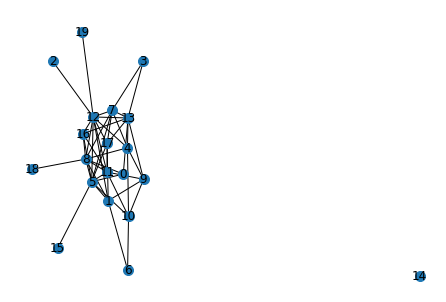

In [5]:
g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=100, with_labels=True)

# Example of simulation from the Block model

In [7]:
%run -i simulator.py

In [8]:
Ncommunities = 10

B = tfp.distributions.Beta(1/2, 2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.5*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))

# print(np.round(B.numpy(), 2))

In [9]:
N = 100
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

# print(E.numpy())

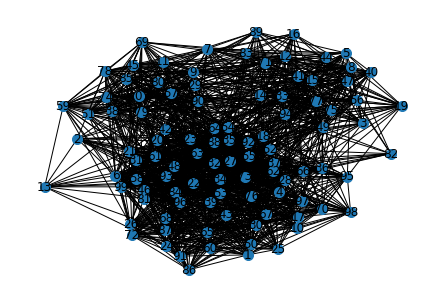

In [10]:
A = simulator.sample(E)

g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=100, with_labels=True)

In [11]:
p, q, eigenvect_eigenval, X = simulator.to_GRDPG(E)
newsimulator = GRDPG(p, q, N)

Xminus = X*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))

M    = tf.einsum("kj,nj->nk", tf.einsum("nk,kj->nj", E, B), E)
newM = tf.einsum("ik,jk->ij", Xminus, X)

newB = tf.linalg.matmul(tf.linalg.matmul(eigenvect_eigenval, tf.linalg.diag(newsimulator.I)), tf.transpose(eigenvect_eigenval))

print("there are "+str(q)+" negative eigenvalues.")
print("we recover B: "+str(tf.reduce_all(tf.abs(B-newB)<1e-5).numpy()))
print("we recover M: "+str(tf.reduce_all(tf.abs(M-newM)<1e-5).numpy()))

there are 2 negative eigenvalues.
we recover B: True
we recover M: True


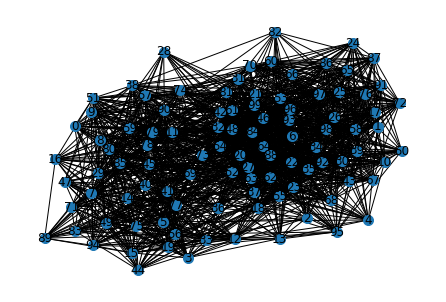

In [12]:
newsimulator = GRDPG(p, q, N)

A = newsimulator.sample(X)
g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=100, with_labels=True)

# Spectral embedding 

In [25]:
Ncommunities = 2

B = tfp.distributions.Beta(1/10, 2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.5*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))
B

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.51593006, 0.04917296],
       [0.04917296, 0.51607454]], dtype=float32)>

In [28]:
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()
initial_distribution

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.38578881, 0.61421119])>

In [29]:
N = 1000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

# g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
# nx.draw(g, node_size=10, with_labels=True)

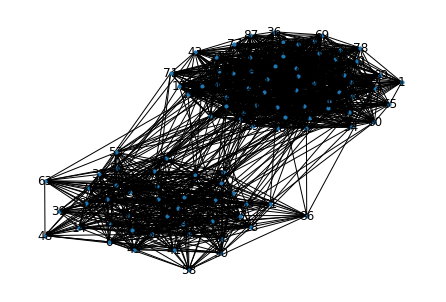

In [30]:
g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=10, with_labels=True)

In [31]:
def d_spectral(A, d):

    eigenvalues, eigenvectors = tf.linalg.eig(A)

    eigenvalues  = tf.math.real(eigenvalues )
    eigenvectors = tf.math.real(eigenvectors)

    eigenvalues  = eigenvalues[-d:]
    eigenvectors = eigenvectors[:,-d:]

    eigenvalues_sort    = tf.sort(   eigenvalues, direction='DESCENDING')
    eigenvalues_argsort = tf.argsort(eigenvalues, direction='DESCENDING')
    eigenvectors_sort   = tf.gather(eigenvectors, eigenvalues_argsort, axis = 1)

    q = sum(eigenvalues_sort.numpy()<0)
    p = eigenvalues_sort.shape[0] - q

    return p, q, tf.einsum("ni,i->ni", eigenvectors_sort, tf.sqrt(tf.abs(eigenvalues_sort)))

In [32]:
d = 2
p, q, hatX = d_spectral(A, d)

In [33]:
newsimulator = GRDPG(p, q, N)

hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))

hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

M = tf.einsum("nj,kj->nk", tf.einsum("nk,kj->nj", E, B), E)
print("the max norm of the difference between M and hatM is "+str(tf.reduce_max(tf.abs(M-hatM)).numpy()))

the max norm of the difference between M and hatM is 0.116523564


# Spectral embedding- TensorLy

In [40]:
Ncommunities = 2

B = tfp.distributions.Beta(1/10, 1/2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.5*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))
B

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.5       , 0.00421517],
       [0.00421517, 0.5011613 ]], dtype=float32)>

In [41]:
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()
initial_distribution

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.62392846, 0.37607154])>

In [42]:
N = 1000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

# g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
# nx.draw(g, node_size=10, with_labels=True)

M = tf.einsum("nj,kj->nk", tf.einsum("nk,kj->nj", E, B), E)

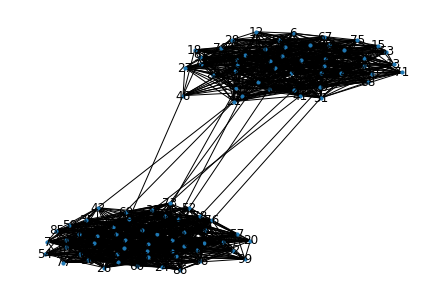

In [43]:
g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=10, with_labels=True)

In [4]:
import tensorly

def d_spectral_tensorly(A, d):

    singularvectors_left, singularvalues, singularvectors_right = tensorly.partial_svd(A.numpy(), n_eigenvecs=d)

    singularvectors_right_subset = singularvectors_right[:,:singularvectors_left.shape[0]]

    sign = tf.sign(tf.experimental.numpy.diagonal(tf.einsum("ni,jn->ij", singularvectors_left, singularvectors_right_subset)))
    singularvalues = sign*singularvalues

    singularvalues_sort        = tf.sort(   singularvalues, direction = 'DESCENDING')
    singularvalues_argsort     = tf.argsort(singularvalues, direction = 'DESCENDING')
    singularvectors_right_sort = tf.gather(singularvectors_right, singularvalues_argsort, axis = 0)

    q = sum((singularvalues<0).numpy())
    p = singularvalues.shape[0] - q

    return p, q, tf.einsum("in,i->ni", singularvectors_right, tf.sqrt(tf.abs(singularvalues)))

In [86]:
d = 2
p, q, hatX = d_spectral_tensorly(A, d)

newsimulator = GRDPG(p, q, N)

hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))

hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

print("the max norm of the difference between M and hatM is "+str(tf.reduce_max(tf.abs(M-hatM)).numpy()))

the max norm of the difference between M and hatM is 0.17114127


# Weighted bootstrap

In [50]:
Ncommunities = 2

B = tfp.distributions.Beta(1/2, 2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.01*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))
B

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.15785383, 0.22392295],
       [0.22392295, 0.06774542]], dtype=float32)>

In [51]:
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()
initial_distribution

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.4526929, 0.5473071])>

In [52]:
N = 1000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

# g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
# nx.draw(g, node_size=10, with_labels=True)

M = tf.einsum("nj,kj->nk", tf.einsum("nk,kj->nj", E, B), E)

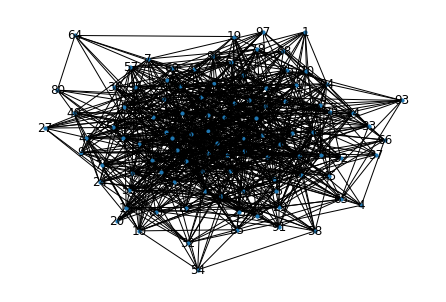

In [53]:
g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=10, with_labels=True)

In [54]:
p, q, eigenvect_eigenval, X = simulator.to_GRDPG(E)

In [154]:
def weighted_bootstrap(iterations, A, d):
    
    p_list = []
    q_list = []
    hatX_list = []

    for i in range(iterations):

        W = tfp.distributions.Exponential(rate = 1).sample(A.shape)
        p, q, hatX = d_spectral_tensorly(W*A, d)

        p_list.append(p)
        q_list.append(q)
        hatX_list.append(hatX)

    return p_list, q_list, hatX_list

# def weighted_bootstrap(iterations, A, d):

#     # Acombined = M
#     W = tfp.distributions.Exponential(rate = 1).sample(A.shape)
#     Acombined = A #W*A

#     for i in range(1, iterations):

#         W = tfp.distributions.Exponential(rate = 1).sample(A.shape)
#         Acombined = tf.concat((Acombined, W*A), axis = 1)

#     p, q, hatXcombined = d_spectral_tensorly(Acombined, d)

#     return p, q, hatXcombined



In [56]:
iterations = 100
d = 2

# p, q, hatXcombined = weighted_bootstrap(iterations, A, d, M)

p_list, q_list, hatX_list = weighted_bootstrap(iterations, A, d)


In [57]:
i = 0

p, q, hatX = p_list[i], q_list[i], hatX_list[i]
newsimulator = GRDPG(p, q, N)
hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

hatMsample = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

for i in range(1, iterations):

    p, q, hatX = p_list[i], q_list[i], hatX_list[i]
    newsimulator = GRDPG(p, q, N)
    hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
    hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

    hatM = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

    hatMsample = tf.concat((hatMsample, hatM), axis = 2)

# i = 0

# hatX = hatXcombined[i*N:(i+1)*N,:]
# newsimulator = GRDPG(p, q, N)
# hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
# hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

# hatMsample = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

# for i in range(1, iterations):

#     hatX = hatXcombined[i*N:(i+1)*N,:]
#     newsimulator = GRDPG(p, q, N)
#     hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
#     hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

#     hatM = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

#     hatMsample = tf.concat((hatMsample, hatM), axis = 2)


In [58]:
# quantileshatM = np.quantile(hatMsample.numpy(), q = (0.025, 0.975), axis = 2)

# print("the empirical coverage of the 0.95 credible interval is "+str((tf.reduce_sum(tf.cast(M>quantileshatM[0,:,:], dtype = tf.float32)*tf.cast(M<quantileshatM[1,:,:], dtype = tf.float32))/(M.shape[0]*M.shape[1])).numpy()))

In [59]:
individual_index = 0

individual_0 = [hatX_list[i][individual_index,:].numpy() for i in range(iterations)]
# individual_0 = [hatXcombined[i*N:(i+1)*N,:][individual_index,:].numpy() for i in range(iterations)]

In [60]:
X.shape

TensorShape([1000, 2])

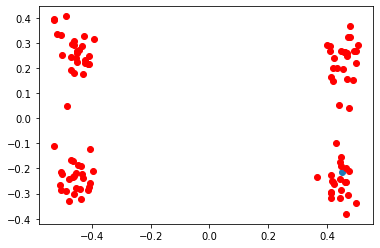

In [61]:
plt.scatter(X[individual_index, 0], X[individual_index, 1])

for i in range(0, iterations):

    plt.scatter(individual_0[i][0], individual_0[i][1], color = "red")

# Spectral embedding bootstrap

In [6]:
Ncommunities = 2

B = tfp.distributions.Beta(1/3, 2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.1*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))
B

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.12343126, 0.06365281],
       [0.06365281, 0.21354723]], dtype=float32)>

In [7]:
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()
initial_distribution

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.68057171, 0.31942829])>

In [8]:
N = 1000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

# g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
# nx.draw(g, node_size=10, with_labels=True)

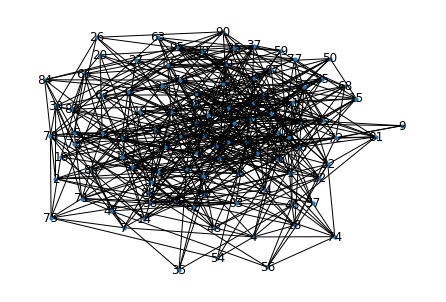

In [9]:
g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=10, with_labels=True)

In [10]:
p, q, eigenvect_eigenval, X = simulator.to_GRDPG(E)

In [153]:
def spectral_bootstrap(iterations, bernoulli_param, A, d):

    p_list = []
    q_list = []
    hatX_list = []

    # A_neigh = tf.cast(tf.einsum("ik,kj->ij", A, A)>1, dtype = tf.float32)
    p, q, hatX = d_spectral_tensorly(A, d)
    newsimulator = GRDPG(p, q, N)
    hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
    hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

    for i in range(iterations):
        
        Xi = tf.cast(tfp.distributions.Bernoulli(probs = hatM).sample(),     dtype = tf.float32)
        M  = tf.cast(tfp.distributions.Bernoulli(probs = bernoulli_param).sample(A.shape), dtype = tf.float32)

        p, q, hatX = d_spectral_tensorly(M*Xi + (1-M)*A, d)

        p_list.append(p)
        q_list.append(q)
        hatX_list.append(hatX)

    return p_list, q_list, hatX_list

# def spectral_bootstrap(iterations, p, A, d):
    
#     p, q, hatX = d_spectral_tensorly(A, d)
#     newsimulator = GRDPG(p, q, N)
#     hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
#     hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

#     Xi = tf.cast(tfp.distributions.Bernoulli(probs = hatM).sample(),     dtype = tf.float32)
#     Mask  = tf.cast(tfp.distributions.Bernoulli(probs = p).sample(A.shape), dtype = tf.float32)

#     Acombined = A #Mask*Xi + (1-Mask)*A #M

#     for i in range(1, iterations):

#         Xi = tf.cast(tfp.distributions.Bernoulli(probs = hatM).sample(),     dtype = tf.float32)
#         Mask  = tf.cast(tfp.distributions.Bernoulli(probs = p).sample(A.shape), dtype = tf.float32)

#         Acombined = tf.concat((Acombined, Mask*Xi + (1-Mask)*A), axis = 1)

#     p, q, hatXcombined = d_spectral_tensorly(Acombined, d)

#     return p, q, hatXcombined



In [46]:
iterations = 100
d = 2

p = 1

p_list, q_list, hatX_list = spectral_bootstrap(iterations, p, A, d)

# M = tf.einsum("nj,kj->nk", tf.einsum("nk,kj->nj", E, B), E)

# p, q, hatXcombined = spectral_bootstrap(iterations, p, A, d)


In [47]:
i = 0

p, q, hatX = p_list[i], q_list[i], hatX_list[i]
newsimulator = GRDPG(p, q, N)
hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

hatMsample = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

for i in range(1, iterations):

    p, q, hatX = p_list[i], q_list[i], hatX_list[i]
    newsimulator = GRDPG(p, q, N)
    hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
    hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

    hatM = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

    hatMsample = tf.concat((hatMsample, hatM), axis = 2)

# i = 0

# hatX = hatXcombined[i*N:(i+1)*N,:]
# newsimulator = GRDPG(p, q, N)
# hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
# hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

# hatMsample = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

# for i in range(1, iterations):

#     hatX = hatXcombined[i*N:(i+1)*N,:]
#     newsimulator = GRDPG(p, q, N)
#     hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
#     hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

#     hatM = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

#     hatMsample = tf.concat((hatMsample, hatM), axis = 2)


In [48]:
individual_index = 100

individual_0 = [hatX_list[i][0,:].numpy() for i in range(iterations)]

# individual_0 = [hatXcombined[i*N:(i+1)*N,:][individual_index,:].numpy() for i in range(iterations)]

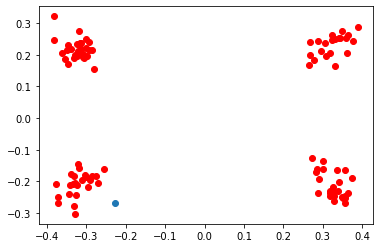

In [49]:
for i in range(1, iterations):

    plt.scatter(individual_0[i][0], individual_0[i][1], color = "red")

plt.scatter(X[individual_index,0], X[individual_index,1])

# Experiment 1

## B without negative eigenvalues

In [135]:
Ncommunities = 2

B                    = tf.convert_to_tensor(np.array([[0.3, 0.005], [0.005, 0.8]], dtype=np.float32))
initial_distribution = 0.5*tf.ones(2)

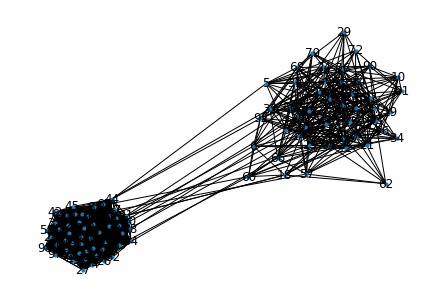

In [136]:
N = 1000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=10, with_labels=True)

In [155]:
iterations = 100
d = 2
bernoulli_param = 1

_, _, spectralhatX_list = spectral_bootstrap(iterations, bernoulli_param, A, d)
_, _, weightedhatX_list = weighted_bootstrap(iterations, A, d)

# _, _, spectralhatX = spectral_bootstrap(iterations, bernoulli_param, A, d)
# _, _, weightedhatX = weighted_bootstrap(iterations, A, d)

In [156]:
p, q, hatX = d_spectral_tensorly(A, d)

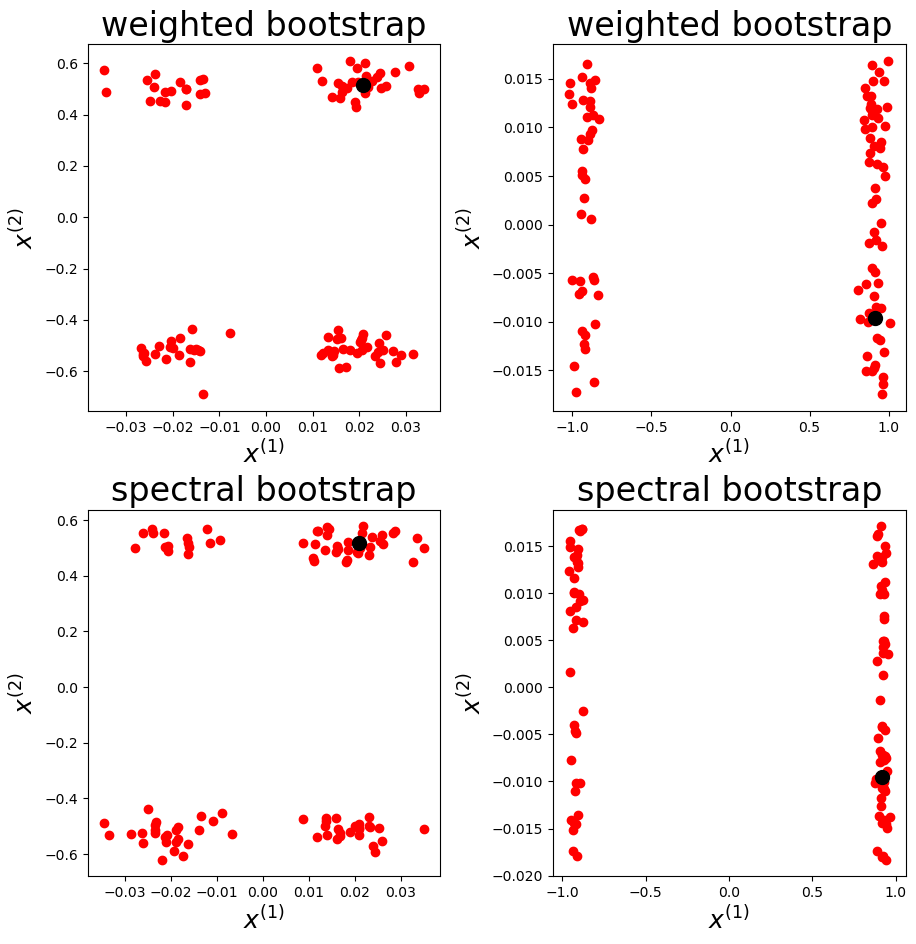

In [173]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10, 10), dpi = 100)
fig.tight_layout(pad=5)

ax[0,0].set_title("weighted bootstrap", fontsize = 24)
ax[0,1].set_title("weighted bootstrap", fontsize = 24)
ax[1,0].set_title("spectral bootstrap", fontsize = 24)
ax[1,1].set_title("spectral bootstrap", fontsize = 24)

ax[0,0].set_xlabel(r"$x^{(1)}$", fontsize = 18)
ax[0,1].set_xlabel(r"$x^{(1)}$", fontsize = 18)
ax[1,0].set_xlabel(r"$x^{(1)}$", fontsize = 18)
ax[1,1].set_xlabel(r"$x^{(1)}$", fontsize = 18)

ax[0,0].set_ylabel(r"$x^{(2)}$", fontsize = 18)
ax[0,1].set_ylabel(r"$x^{(2)}$", fontsize = 18)
ax[1,0].set_ylabel(r"$x^{(2)}$", fontsize = 18)
ax[1,1].set_ylabel(r"$x^{(2)}$", fontsize = 18)

individual_index = 0

individual_0 = [weightedhatX_list[i][individual_index,:].numpy() for i in range(iterations)] #[weightedhatX[i*N:(i+1)*N,:][individual_index,:].numpy() for i in range(iterations)] 

for i in range(0, iterations):
    
    ax[0,0].scatter(individual_0[i][0], individual_0[i][1], color = "red")

# ax[0,0].scatter(X[individual_index,1], X[individual_index,0])
ax[0,0].scatter(hatX[individual_index,0], hatX[individual_index,1], color = "black", s = 100)

individual_index = 1
individual_0 = [weightedhatX_list[i][individual_index,:].numpy() for i in range(iterations)] #[weightedhatX[i*N:(i+1)*N,:][individual_index,:].numpy() for i in range(iterations)] 

for i in range(0, iterations):
    
    ax[0,1].scatter(individual_0[i][0], individual_0[i][1], color = "red")

# ax[0,1].scatter(X[individual_index,1], X[individual_index,0])
ax[0,1].scatter(hatX[individual_index,0], hatX[individual_index,1], color = "black", s = 100)

individual_index = 0

individual_0 = [spectralhatX_list[i][individual_index,:].numpy() for i in range(iterations)] #[spectralhatX[i*N:(i+1)*N,:][individual_index,:].numpy() for i in range(iterations)] 

for i in range(0, iterations):
    
    ax[1,0].scatter(individual_0[i][0], individual_0[i][1], color = "red")

# ax[1,0].scatter(X[individual_index,1], X[individual_index,0])
ax[1,0].scatter(hatX[individual_index,0], hatX[individual_index,1], color = "black", s = 100)

individual_index = 1
individual_0 = [spectralhatX_list[i][individual_index,:].numpy() for i in range(iterations)] #[spectralhatX[i*N:(i+1)*N,:][individual_index,:].numpy() for i in range(iterations)] 

for i in range(0, iterations):
    
    ax[1,1].scatter(individual_0[i][0], individual_0[i][1], color = "red")

# ax[1,1].scatter(X[individual_index,1], X[individual_index,0])
ax[1,1].scatter(hatX[individual_index,0], hatX[individual_index,1], color = "black", s = 100)

## B without negative eigenvalues

In [182]:
Ncommunities = 2

B                    = tf.convert_to_tensor(np.array([[0.05, 0.3], 
                                                      [0.3, 0.01]], dtype=np.float32))
initial_distribution = 0.5*tf.ones(2)

In [183]:
tf.eig(B)

(<tf.Tensor: shape=(2,), dtype=complex64, numpy=array([-0.27066594+0.j,  0.33066595+0.j], dtype=complex64)>,
 <tf.Tensor: shape=(2, 2), dtype=complex64, numpy=
 array([[-0.6831841 +0.j,  0.73024625+0.j],
        [ 0.7302462 +0.j,  0.683184  +0.j]], dtype=complex64)>)

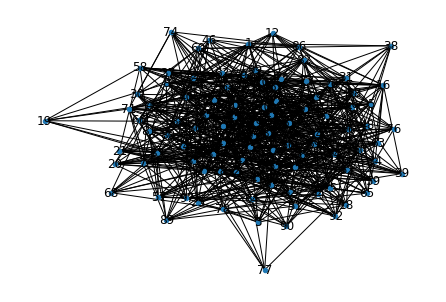

In [185]:
N = 1000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=20, with_labels=True)

In [186]:
iterations = 100
d = 2
bernoulli_param = 1

_, _, spectralhatX_list = spectral_bootstrap(iterations, bernoulli_param, A, d)
_, _, weightedhatX_list = weighted_bootstrap(iterations, A, d)

# _, _, spectralhatX = spectral_bootstrap(iterations, bernoulli_param, A, d)
# _, _, weightedhatX = weighted_bootstrap(iterations, A, d)

In [187]:
p, q, hatX = d_spectral_tensorly(A, d)

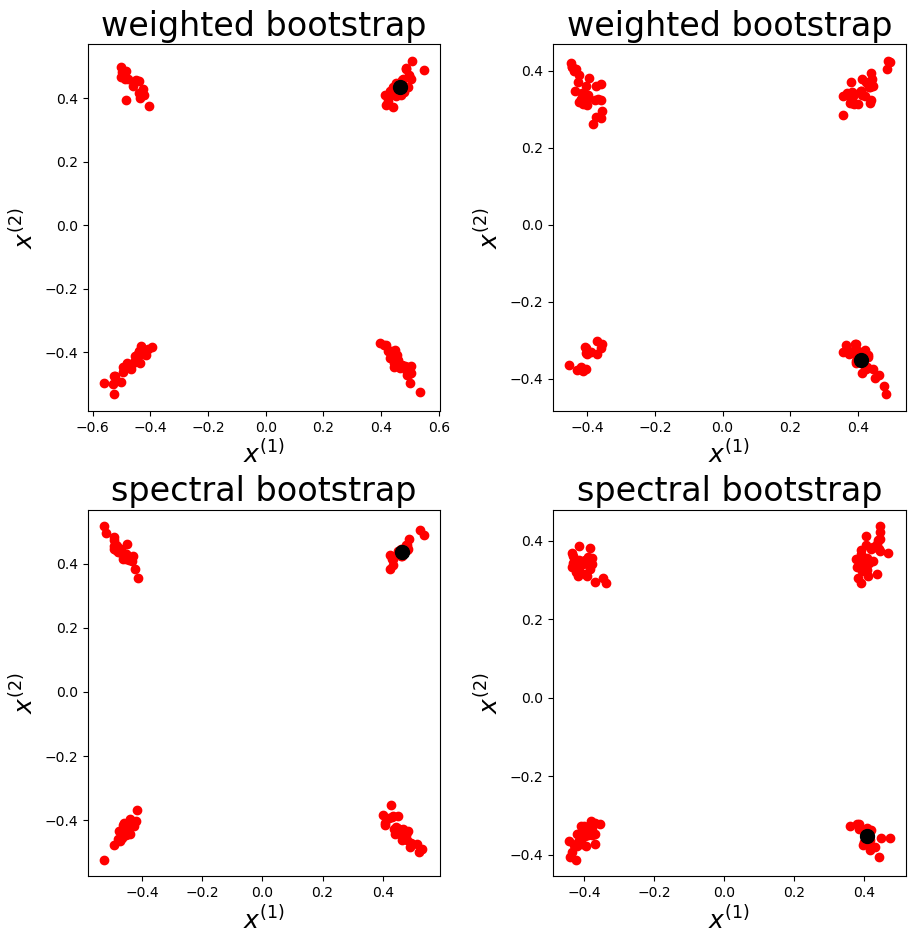

In [192]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10, 10), dpi = 100)
fig.tight_layout(pad=5)

ax[0,0].set_title("weighted bootstrap", fontsize = 24)
ax[0,1].set_title("weighted bootstrap", fontsize = 24)
ax[1,0].set_title("spectral bootstrap", fontsize = 24)
ax[1,1].set_title("spectral bootstrap", fontsize = 24)

ax[0,0].set_xlabel(r"$x^{(1)}$", fontsize = 18)
ax[0,1].set_xlabel(r"$x^{(1)}$", fontsize = 18)
ax[1,0].set_xlabel(r"$x^{(1)}$", fontsize = 18)
ax[1,1].set_xlabel(r"$x^{(1)}$", fontsize = 18)

ax[0,0].set_ylabel(r"$x^{(2)}$", fontsize = 18)
ax[0,1].set_ylabel(r"$x^{(2)}$", fontsize = 18)
ax[1,0].set_ylabel(r"$x^{(2)}$", fontsize = 18)
ax[1,1].set_ylabel(r"$x^{(2)}$", fontsize = 18)

individual_index = 0

individual_0 = [weightedhatX_list[i][individual_index,:].numpy() for i in range(iterations)] #[weightedhatX[i*N:(i+1)*N,:][individual_index,:].numpy() for i in range(iterations)] 

for i in range(0, iterations):
    
    ax[0,0].scatter(individual_0[i][0], individual_0[i][1], color = "red")

# ax[0,0].scatter(X[individual_index,1], X[individual_index,0])
ax[0,0].scatter(hatX[individual_index,0], hatX[individual_index,1], color = "black", s = 100)

individual_index = 1
individual_0 = [weightedhatX_list[i][individual_index,:].numpy() for i in range(iterations)] #[weightedhatX[i*N:(i+1)*N,:][individual_index,:].numpy() for i in range(iterations)] 

for i in range(0, iterations):
    
    ax[0,1].scatter(individual_0[i][0], individual_0[i][1], color = "red")

# ax[0,1].scatter(X[individual_index,1], X[individual_index,0])
ax[0,1].scatter(hatX[individual_index,0], hatX[individual_index,1], color = "black", s = 100)

individual_index = 0

individual_0 = [spectralhatX_list[i][individual_index,:].numpy() for i in range(iterations)] #[spectralhatX[i*N:(i+1)*N,:][individual_index,:].numpy() for i in range(iterations)] 

for i in range(0, iterations):
    
    ax[1,0].scatter(individual_0[i][0], individual_0[i][1], color = "red")

# ax[1,0].scatter(X[individual_index,1], X[individual_index,0])
ax[1,0].scatter(hatX[individual_index,0], hatX[individual_index,1], color = "black", s = 100)

individual_index = 1
individual_0 = [spectralhatX_list[i][individual_index,:].numpy() for i in range(iterations)] #[spectralhatX[i*N:(i+1)*N,:][individual_index,:].numpy() for i in range(iterations)] 

for i in range(0, iterations):
    
    ax[1,1].scatter(individual_0[i][0], individual_0[i][1], color = "red")

# ax[1,1].scatter(X[individual_index,1], X[individual_index,0])
ax[1,1].scatter(hatX[individual_index,0], hatX[individual_index,1], color = "black", s = 100)

In [193]:
E

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)>